<a href="https://colab.research.google.com/github/adheeb4/7PAM2002_0509_2023_Final_Project/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from google.colab import files
from google.colab import drive
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/MyDrive/Data/'

fundamentals_df = pd.read_csv(file_path + 'fundamentals.csv')
prices_df = pd.read_csv(file_path + 'prices.csv')
prices_split_adjusted_df = pd.read_csv(file_path + 'prices-split-adjusted.csv')
securities_df = pd.read_csv(file_path + 'securities.csv')


prices_df['date'] = pd.to_datetime(prices_df['date'], format='mixed')

# Format the 'date' column to 'YYYY-MM-DD'
prices_df['date'] = prices_df['date'].dt.strftime('%Y-%m-%d')



print("Fundamentals Data")
print(fundamentals_df.head())

print("\nPrices Data")
print(prices_df.head())

print("\nPrices Split Adjusted Data")
print(prices_split_adjusted_df.head())

print("\nSecurities Data")
print(securities_df.head())

Fundamentals Data
   Unnamed: 0 Ticker Symbol Period Ending  Accounts Payable  \
0           0           AAL    2012-12-31      3.068000e+09   
1           1           AAL    2013-12-31      4.975000e+09   
2           2           AAL    2014-12-31      4.668000e+09   
3           3           AAL    2015-12-31      5.102000e+09   
4           4           AAP    2012-12-29      2.409453e+09   

   Accounts Receivable  Add'l income/expense items  After Tax ROE  \
0         -222000000.0               -1.961000e+09           23.0   
1          -93000000.0               -2.723000e+09           67.0   
2         -160000000.0               -1.500000e+08          143.0   
3          352000000.0               -7.080000e+08          135.0   
4          -89482000.0                6.000000e+05           32.0   

   Capital Expenditures  Capital Surplus  Cash Ratio  ...  \
0         -1.888000e+09     4.695000e+09        53.0  ...   
1         -3.114000e+09     1.059200e+10        75.0  ...   
2    

In [4]:
print(prices_df)

              date symbol        open       close         low        high  \
0       2016-01-05   WLTW  123.430000  125.839996  122.309998  126.250000   
1       2016-01-06   WLTW  125.239998  119.980003  119.940002  125.540001   
2       2016-01-07   WLTW  116.379997  114.949997  114.930000  119.739998   
3       2016-01-08   WLTW  115.480003  116.620003  113.500000  117.440002   
4       2016-01-11   WLTW  117.010002  114.970001  114.089996  117.330002   
...            ...    ...         ...         ...         ...         ...   
851259  2016-12-30    ZBH  103.309998  103.199997  102.849998  103.930000   
851260  2016-12-30   ZION   43.070000   43.040001   42.689999   43.310001   
851261  2016-12-30    ZTS   53.639999   53.529999   53.270000   53.740002   
851262  2016-12-30    AIV   44.730000   45.450001   44.410000   45.590000   
851263  2016-12-30    FTV   54.200001   53.630001   53.389999   54.480000   

           volume  
0       2163600.0  
1       2386400.0  
2       2489500

In [5]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [6]:
def plotCorrelationMatrix(df, graphWidth, filename='DataFrame'):
    # Ensure the DataFrame only contains numeric columns
    df = df.select_dtypes(include=[float, int])
    df = df.dropna(axis='columns')  # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]]  # keep columns with more than 1 unique value

    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return

    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum=1)

    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)

    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [7]:
def plotScatterMatrix(df, plotSize, textSize, maxColumns=10):
    # Ensure the DataFrame only contains numeric columns
    df = df.select_dtypes(include=[np.number])

    # Remove rows and columns that would lead to df being singular
    df = df.dropna(axis='columns')
    df = df[[col for col in df if df[col].nunique() > 1]]  # keep columns where there are more than 1 unique value

    if df.shape[1] < 2:
        print(f'No scatter matrix plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return

    # Limit the number of columns
    if df.shape[1] > maxColumns:
        print(f'Too many columns to display ({df.shape[1]}), displaying the first {maxColumns} columns.')
        df = df.iloc[:, :maxColumns]

    columnNames = list(df)
    df = df[columnNames].dropna()

    # Create scatter matrix
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=(plotSize, plotSize), diagonal='kde')

    # Add title
    corr = df.corr().values
    for i, j in zip(*np.triu_indices_from(corr, 1)):
        ax[i, j].annotate(f'{corr[i, j]:.2f}', (0.8, 0.2), textcoords='axes fraction', ha='center', va='center', fontsize=textSize)

    plt.suptitle('Scatter Matrix')
    plt.show()

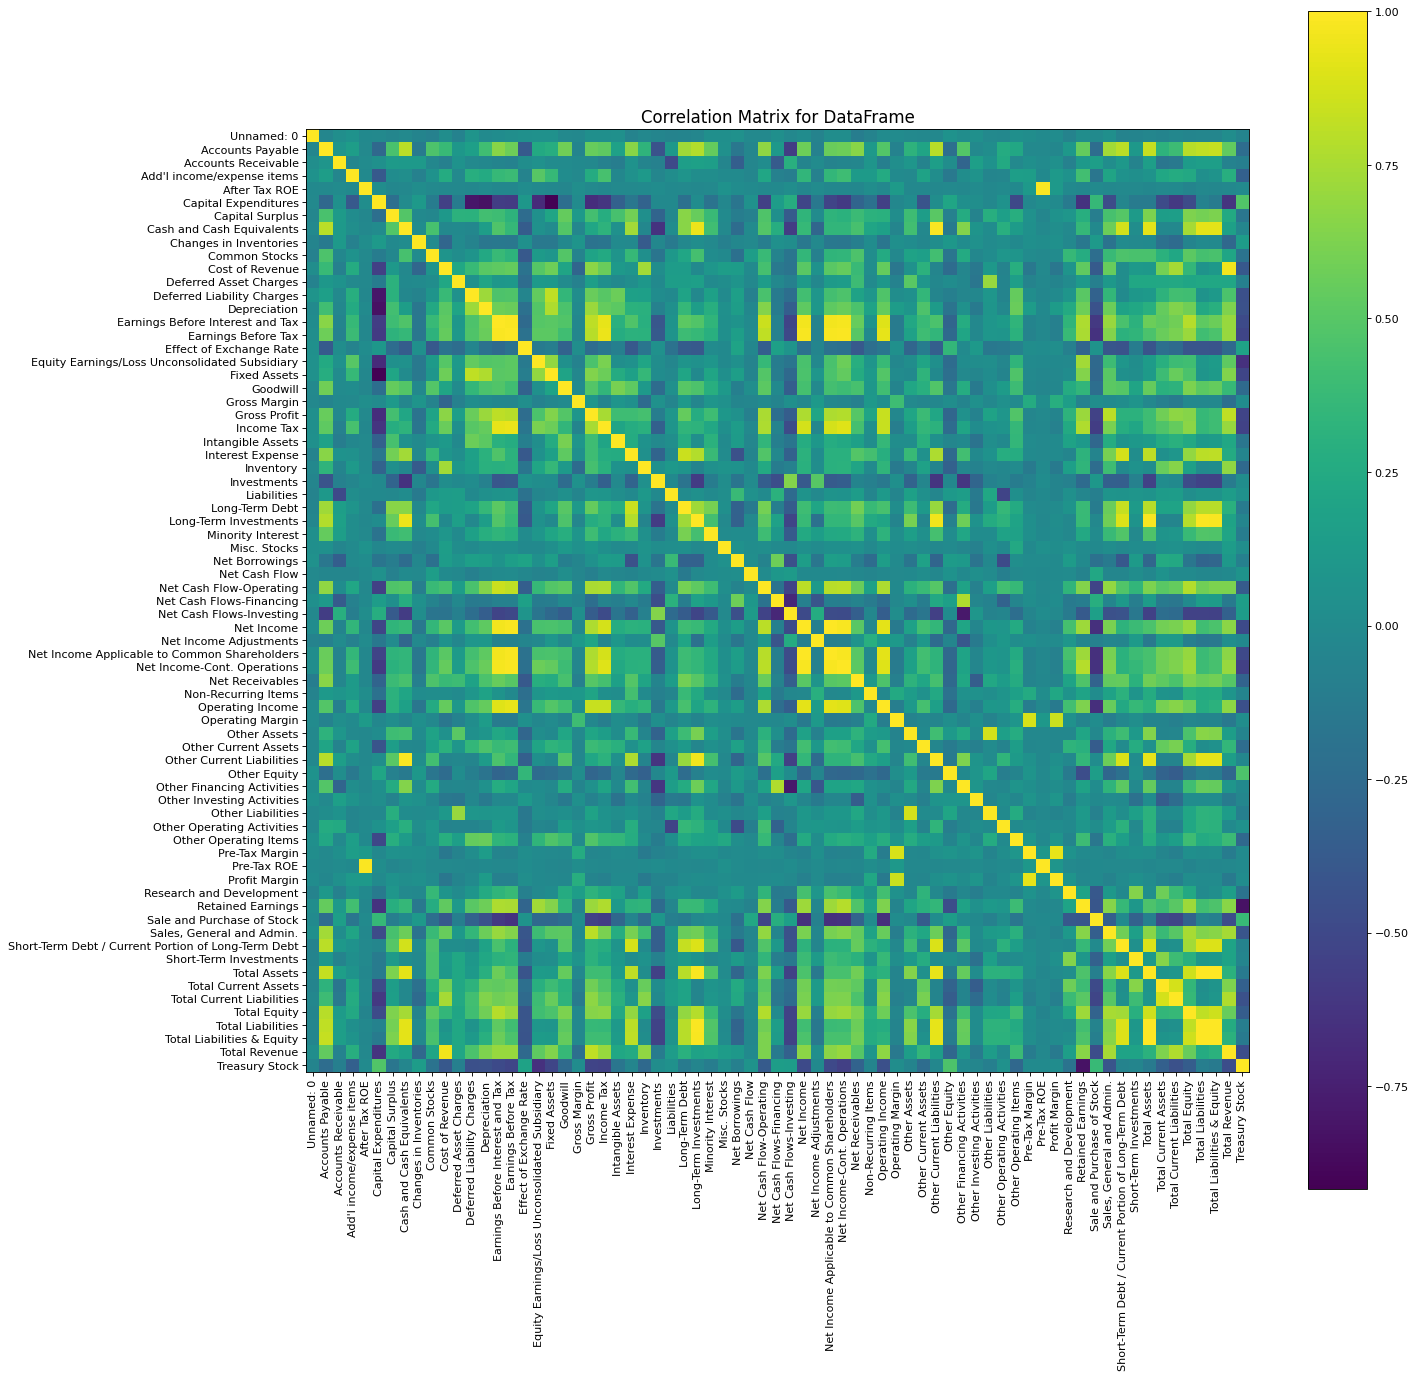

In [8]:
plotCorrelationMatrix(fundamentals_df, 19)

Too many columns to display (71), displaying the first 10 columns.


<ipython-input-7-d8ec7bf7104e>:27: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  ax[i, j].annotate(f'{corr[i, j]:.2f}', (0.8, 0.2), textcoords='axes fraction', ha='center', va='center', fontsize=textSize)


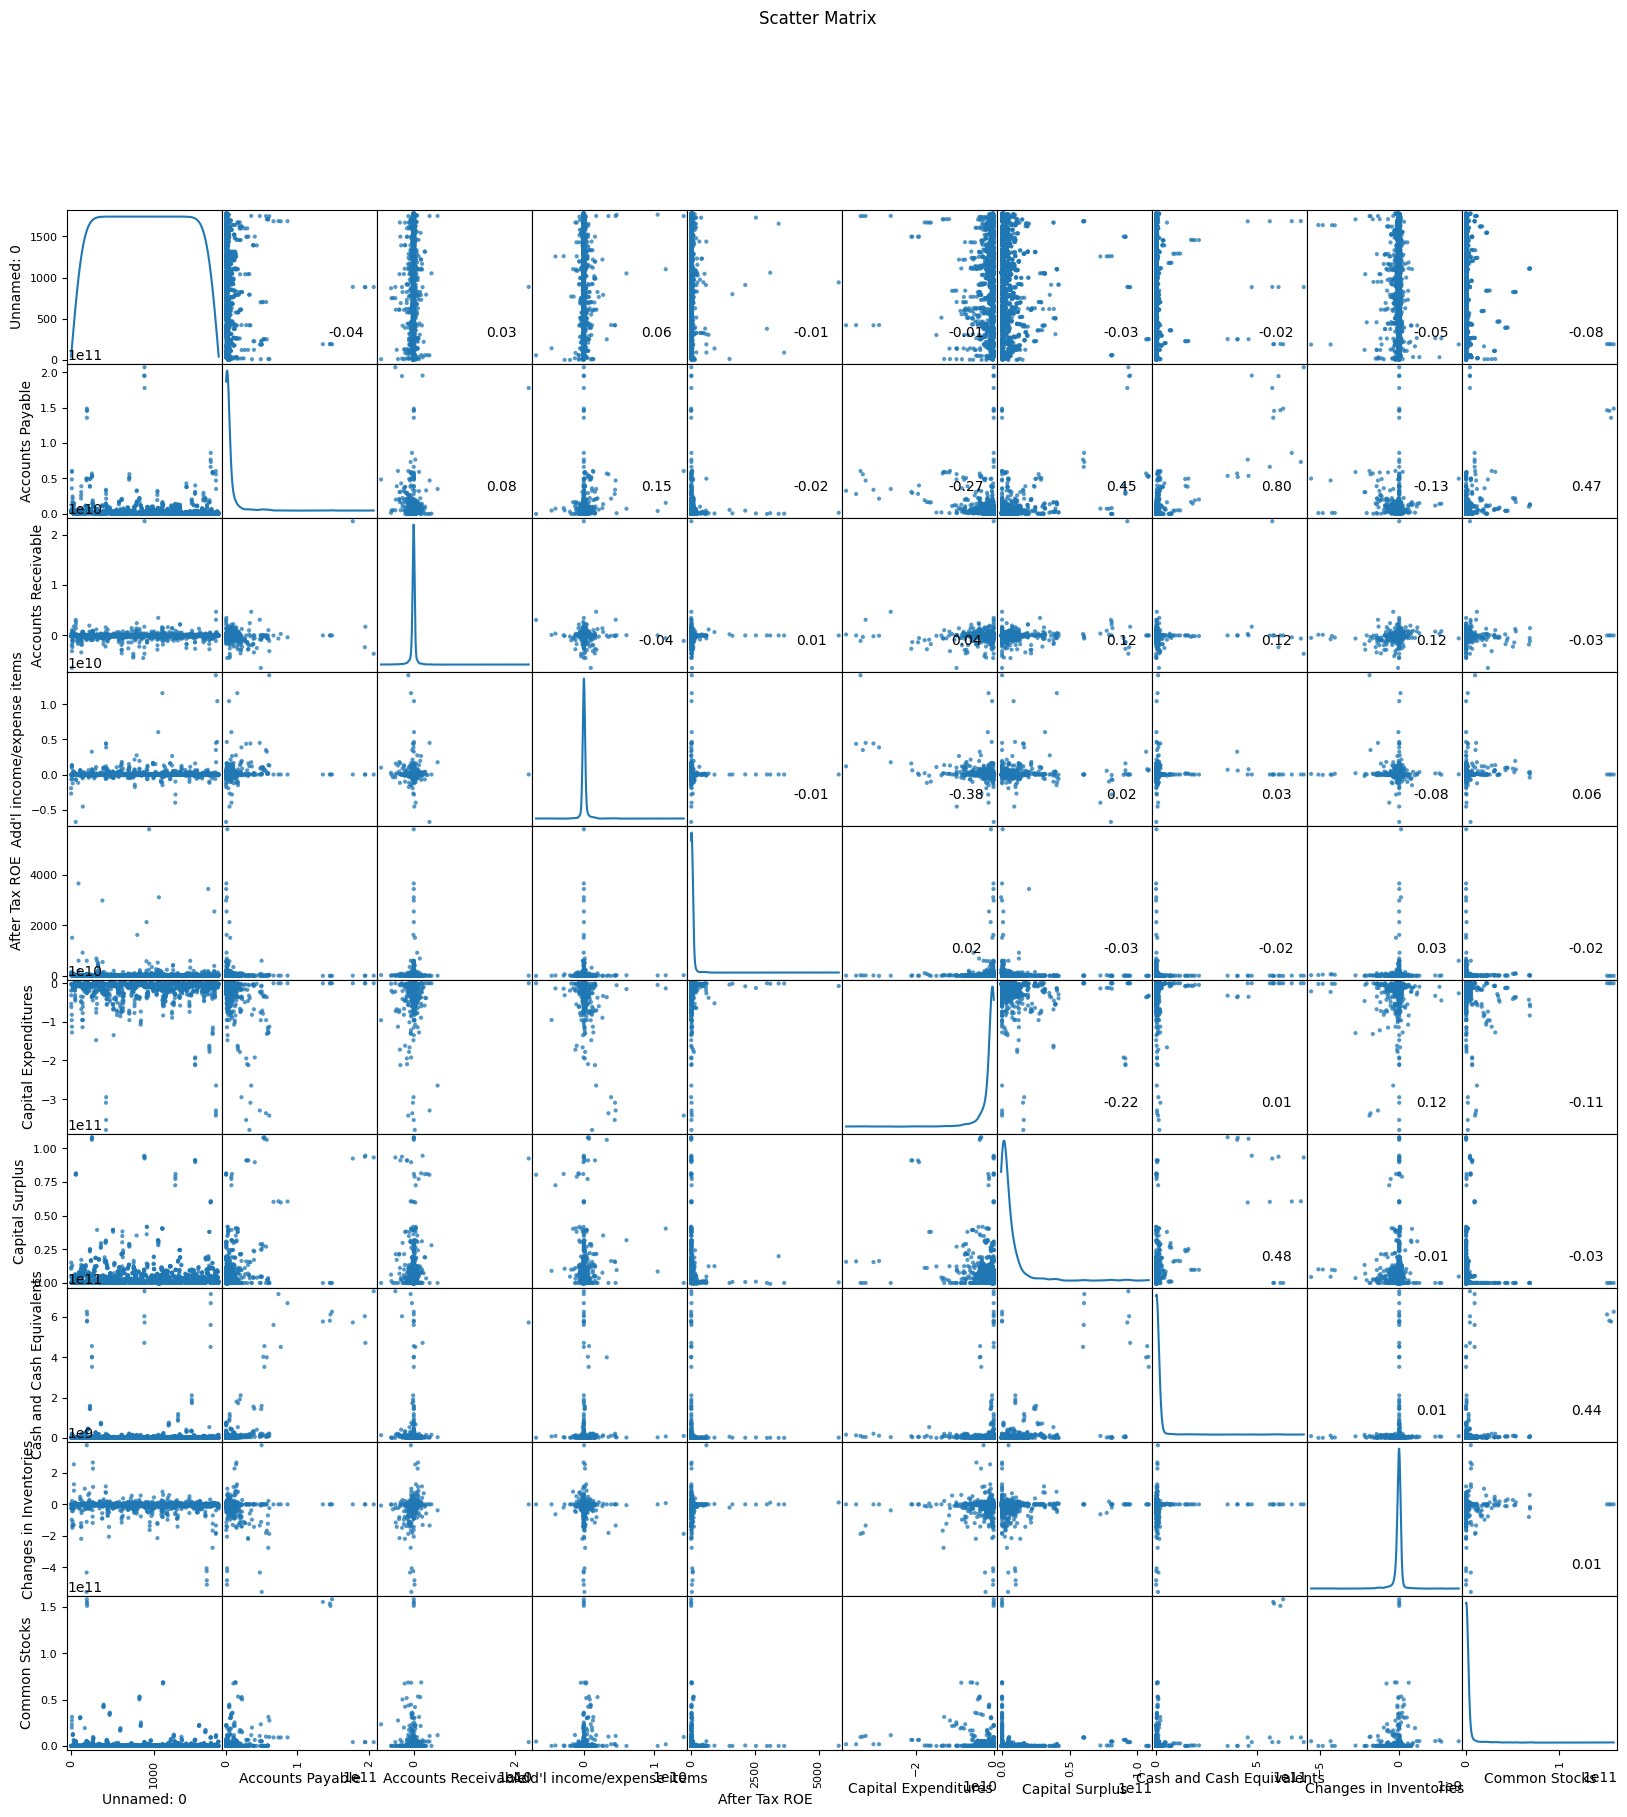

In [9]:
plotScatterMatrix(fundamentals_df, 20, 10)

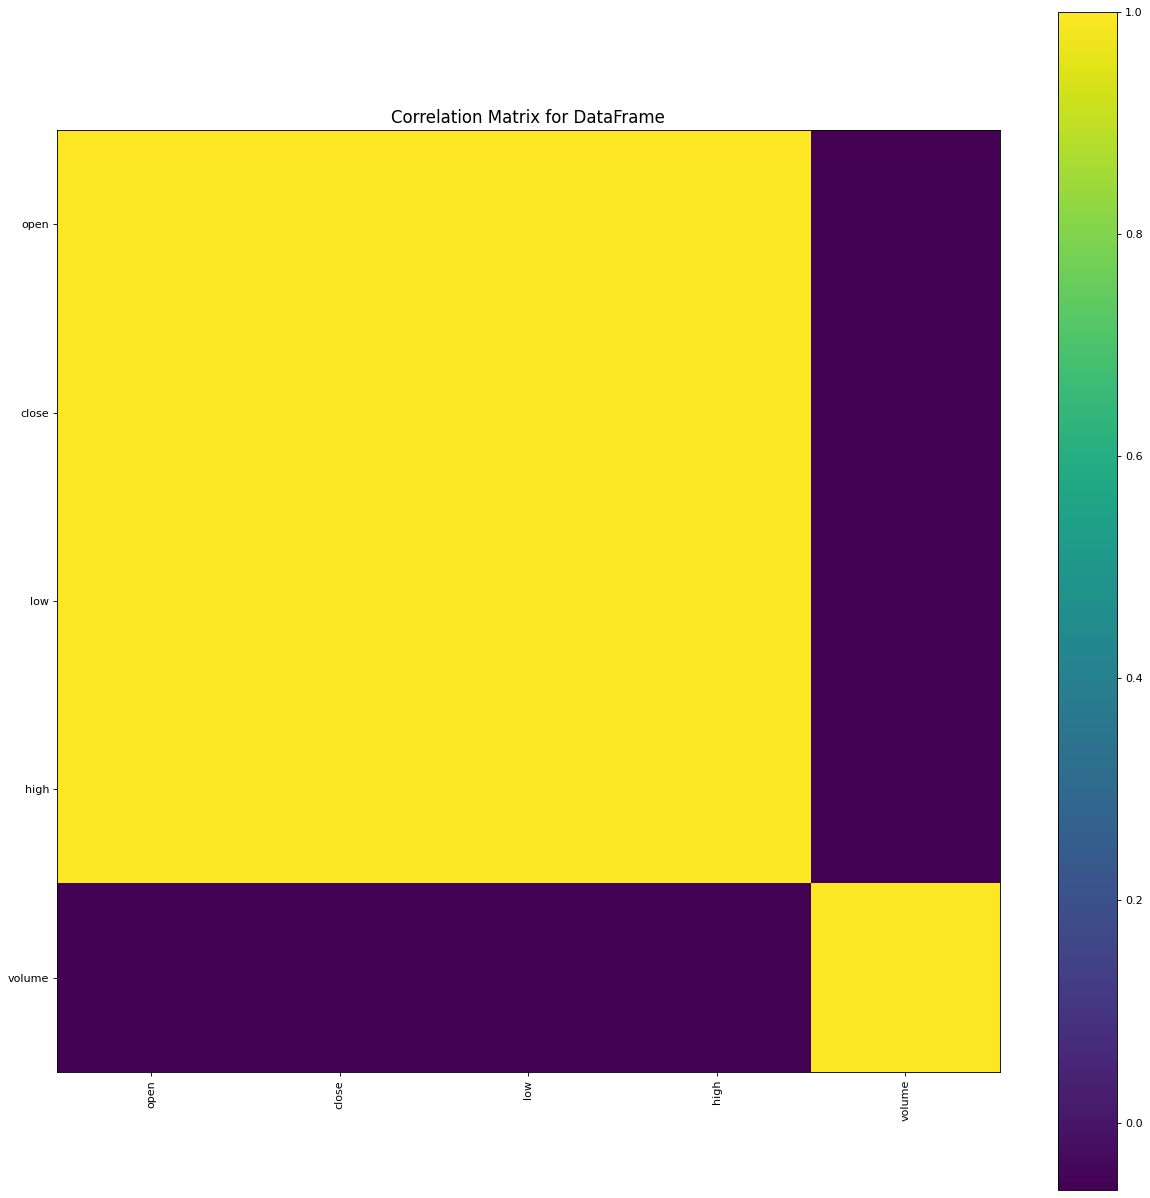

In [10]:
plotCorrelationMatrix(prices_df, 19)

In [11]:
plotScatterMatrix(prices_df, 19, 10)

<ipython-input-7-d8ec7bf7104e>:27: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  ax[i, j].annotate(f'{corr[i, j]:.2f}', (0.8, 0.2), textcoords='axes fraction', ha='center', va='center', fontsize=textSize)


KeyboardInterrupt: 

In [12]:
def extract_date_features(df, date_col='date', date_format='%Y-%m-%d'):
    df[date_col] = pd.to_datetime(df[date_col], format=date_format, errors='coerce')
    df['year'] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month
    df['day'] = df[date_col].dt.day
    df['day_of_week'] = df[date_col].dt.dayofweek
    return df


In [13]:
df = extract_date_features(prices_df)

In [14]:
df['prev_close'] = df.groupby('symbol')['close'].shift(1)
df['close_rolling_mean_7'] = df.groupby('symbol')['close'].transform(lambda x: x.rolling(window=7).mean())
df['close_rolling_std_7'] = df.groupby('symbol')['close'].transform(lambda x: x.rolling(window=7).std())

In [19]:
prices_df['daily_return'] = prices_df.groupby('symbol')['close'].pct_change()


In [20]:
fundamentals_df['debt_to_equity'] = fundamentals_df['Total Liabilities'] / fundamentals_df['Total Equity']
fundamentals_df['current_ratio'] = fundamentals_df['Total Current Assets'] / fundamentals_df['Total Current Liabilities']
fundamentals_df['return_on_assets'] = fundamentals_df['Net Income'] / fundamentals_df['Total Assets']

In [21]:
combined_df = pd.merge(prices_df, fundamentals_df, left_on=['symbol', 'year'], right_on=['Ticker Symbol', 'For Year'], how='left')

In [22]:
print(combined_df.head())

        date symbol        open       close         low        high  \
0 2016-01-05   WLTW  123.430000  125.839996  122.309998  126.250000   
1 2016-01-06   WLTW  125.239998  119.980003  119.940002  125.540001   
2 2016-01-07   WLTW  116.379997  114.949997  114.930000  119.739998   
3 2016-01-08   WLTW  115.480003  116.620003  113.500000  117.440002   
4 2016-01-11   WLTW  117.010002  114.970001  114.089996  117.330002   

      volume  year  month  day  ...  Total Liabilities  \
0  2163600.0  2016      1    5  ...                NaN   
1  2386400.0  2016      1    6  ...                NaN   
2  2489500.0  2016      1    7  ...                NaN   
3  2006300.0  2016      1    8  ...                NaN   
4  1408600.0  2016      1   11  ...                NaN   

   Total Liabilities & Equity  Total Revenue  Treasury Stock  For Year  \
0                         NaN            NaN             NaN       NaN   
1                         NaN            NaN             NaN       NaN   
2 

In [ ]:
output_file_path = '/content/drive/MyDrive/Data/combined_data.csv'
combined_df.to_csv(output_file_path, index=False)

print(f"Combined dataframe exported to {output_file_path}")